# Visualize embeddings

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from dawnet.inspector import LLMInspector
from dawnet.tokens import Tokens
from dawnet import op

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
model_id = "allenai/Olmo-3-1025-7B"
insp = LLMInspector.from_hf(model_id)

`rope_scaling`'s beta_fast field must be a float, got 32
`rope_scaling`'s beta_slow field must be a float, got 1


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
insp.model

Olmo3ForCausalLM(
  (model): Olmo3Model(
    (embed_tokens): Embedding(100278, 4096, padding_idx=100277)
    (layers): ModuleList(
      (0-31): 32 x Olmo3DecoderLayer(
        (self_attn): Olmo3Attention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_norm): Olmo3RMSNorm((4096,), eps=1e-06)
          (k_norm): Olmo3RMSNorm((4096,), eps=1e-06)
        )
        (mlp): Olmo3MLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (post_attention_layernorm): Olmo3RMSNorm((4096,), eps=1e-06)
     

## Check the King-Queen common use case

The embeddings from LLM don't have the same mathematical formulation as word2vec.

In [6]:
embed_layer = insp.model.model.embed_tokens

In [7]:
king, queen = " king", " queen"
man, woman = " man", " woman"

In [8]:
king_emb = embed_layer(insp.tokenizer.encode(king, return_tensors="pt").to(device)).squeeze()
queen_emb = embed_layer(insp.tokenizer.encode(queen, return_tensors="pt").to(device)).squeeze()
man_emb = embed_layer(insp.tokenizer.encode(man, return_tensors="pt").to(device)).squeeze()
woman_emb = embed_layer(insp.tokenizer.encode(woman, return_tensors="pt").to(device)).squeeze()

In [9]:
print(f"{king_emb=}")
print(f"{queen_emb=}")
print(f"{man_emb=}")
print(f"{woman_emb=}")

king_emb=tensor([-5.7373e-02, -4.6015e-05,  1.8433e-02,  ..., -2.8442e-02,
        -2.6001e-02,  8.9111e-03], device='mps:0')
queen_emb=tensor([-0.0435, -0.0014, -0.0068,  ...,  0.0039, -0.0130, -0.0022],
       device='mps:0')
man_emb=tensor([ 0.0135, -0.0410,  0.0153,  ...,  0.0014,  0.0022,  0.0154],
       device='mps:0')
woman_emb=tensor([ 0.0317, -0.0330, -0.0248,  ..., -0.0273, -0.0093, -0.0220],
       device='mps:0')


In [10]:
king_emb - queen_emb

tensor([-0.0139,  0.0014,  0.0252,  ..., -0.0323, -0.0130,  0.0112],
       device='mps:0')

In [11]:
man_emb - woman_emb

tensor([-0.0182, -0.0081,  0.0401,  ...,  0.0287,  0.0114,  0.0374],
       device='mps:0')

In [12]:
man_emb - woman_emb + queen_emb

tensor([-0.0616, -0.0095,  0.0333,  ...,  0.0326, -0.0016,  0.0351],
       device='mps:0')

In [13]:
king_emb

tensor([-5.7373e-02, -4.6015e-05,  1.8433e-02,  ..., -2.8442e-02,
        -2.6001e-02,  8.9111e-03], device='mps:0')

In [14]:
F.cosine_similarity(king_emb, queen_emb, dim=0)

tensor(0.3412, device='mps:0')

In [15]:
F.cosine_similarity(man_emb, woman_emb, dim=0)

tensor(0.3838, device='mps:0')

In [16]:
F.cosine_similarity(king_emb, man_emb - woman_emb + queen_emb, dim=0)

tensor(0.2744, device='mps:0')

In [17]:
((king_emb - woman_emb)**2).sum()

tensor(1.3488, device='mps:0')

In [18]:
((king_emb - (man_emb - woman_emb + queen_emb))**2).sum()

tensor(1.7163, device='mps:0')

In [19]:
def cosine_similarity_between_words(word1, word2):
    word1_embed = embed_layer(insp.tokenizer.encode(word1, return_tensors="pt").to(device)).squeeze()
    word2_embed = embed_layer(insp.tokenizer.encode(word2, return_tensors="pt").to(device)).squeeze()
    cosine_simlarity = F.cosine_similarity(word1_embed, word2_embed, dim=0).cpu().item()
    l2_dist = ((word1_embed - word2_embed)**2).sum().cpu().item()
    print(f"{word1}-{word2}:", 'cos:', round(cosine_simlarity, 3), 'l2 dist:', round(l2_dist, 3))

In [60]:
cosine_similarity_between_words("king", " king")

king- king: cos: 0.569 l2 dist: 1.118


In [61]:
cosine_similarity_between_words("king", " queen")

king- queen: cos: 0.328 l2 dist: 1.719


In [62]:
cosine_similarity_between_words("king", "queen")

king-queen: cos: 0.282 l2 dist: 1.963


In [63]:
cosine_similarity_between_words("king", " man")

king- man: cos: -0.001 l2 dist: 2.61


In [64]:
cosine_similarity_between_words("king", "man")

king-man: cos: 0.032 l2 dist: 2.528


In [65]:
cosine_similarity_between_words(" king", " man")

 king- man: cos: 0.072 l2 dist: 2.064


In [20]:
cosine_similarity_between_words("king", " king")

king- king: cos: 0.373 l2 dist: 1.016


In [21]:
cosine_similarity_between_words("king", " queen")

king- queen: cos: 0.168 l2 dist: 1.473


In [23]:
cosine_similarity_between_words("king", "queen")

king-queen: cos: 0.196 l2 dist: 1.457


In [27]:
cosine_similarity_between_words(" king", " man")

 king- man: cos: 0.114 l2 dist: 1.202


In [26]:
cosine_similarity_between_words("king", "man")

king-man: cos: 0.072 l2 dist: 1.369


In [29]:
F.cosine_similarity(king_emb, man_emb, dim=0)

tensor(0.1137, device='mps:0')

In [28]:
F.cosine_similarity(king_emb, man_emb - woman_emb + queen_emb, dim=0)

tensor(0.2744, device='mps:0')

In [30]:
F.cosine_similarity(king_emb, man_emb + queen_emb, dim=0)

tensor(0.3233, device='mps:0')

In [35]:
F.cosine_similarity(man_emb, (man_emb+woman_emb), dim=0)

tensor(0.8150, device='mps:0')

In [36]:
F.cosine_similarity(king_emb, man_emb + woman_emb, dim=0)

tensor(0.1178, device='mps:0')

In [37]:
F.cosine_similarity(king_emb, queen_emb, dim=0)

tensor(0.3412, device='mps:0')

In [38]:
cosine_similarity_between_words(" king", " queen")

 king- queen: cos: 0.341 l2 dist: 1.098


In [39]:
cosine_similarity_between_words(" man", " woman")

 man- woman: cos: 0.384 l2 dist: 0.812


In [52]:
cosine_similarity_between_words(" Paris", " king")

 Paris- king: cos: 0.039 l2 dist: 1.793


In [53]:
cosine_similarity_between_words(" London", " king")

 London- king: cos: 0.057 l2 dist: 1.661


### Check embedding from different models

In [54]:
model_id2 = "Qwen/Qwen3-4B-Thinking-2507"
insp2 = LLMInspector.from_hf(model_id2).to(device=device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [55]:
insp2.model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((2560,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [59]:
embed_layer2 = insp2.model.model.embed_tokens

In [60]:
def cosine_similarity_between_words2(word1, word2):
    word1_embed = embed_layer2(insp2.tokenizer.encode(word1, return_tensors="pt").to(device)).squeeze()
    word2_embed = embed_layer2(insp2.tokenizer.encode(word2, return_tensors="pt").to(device)).squeeze()
    cosine_simlarity = F.cosine_similarity(word1_embed, word2_embed, dim=0).cpu().item()
    l2_dist = ((word1_embed - word2_embed)**2).sum().cpu().item()
    print(f"{word1}-{word2}:", 'cos:', round(cosine_simlarity, 3), 'l2 dist:', round(l2_dist, 3))

In [61]:
cosine_similarity_between_words2(" king", " queen")

 king- queen: cos: 0.556 l2 dist: 0.959


In [62]:
cosine_similarity_between_words2(" man", " woman")

 man- woman: cos: 0.327 l2 dist: 1.364


In [63]:
cosine_similarity_between_words2(" Paris", " king")

 Paris- king: cos: 0.043 l2 dist: 1.984


In [65]:
cosine_similarity_between_words2(" London", " king")

 London- king: cos: 0.051 l2 dist: 1.878


## Visualize embeddings

### With PCA

In [4]:
categories = ["boy_first_names", "girl_first_names", "countries", "capitals", "colors", "months", "emotions", "action_verbs", "occupations"]
word_lists = {
    "boy_first_names": [
        "James", "John", "Michael", "David", "Daniel",
        "Matthew", "Andrew", "Thomas", "Mark", "Paul",
        "Peter", "Kevin", "Brian"
    ],
    
    "girl_first_names": [
        "Mary", "Sarah", "Emma", "Emily", "Jessica",
        "Anna", "Laura", "Lisa", "Jennifer", "Karen",
        "Amy", "Rachel", "Susan"
    ],
    
    "countries": [
        "France", "Spain", "Italy", "Japan", "China",
        "Brazil", "Canada", "Mexico", "India", "Egypt",
        "Greece", "Turkey", "Peru"
    ],
    
    "capitals": [
        "Paris", "London", "Rome", "Tokyo", "Berlin",
        "Madrid", "Ottawa", "Cairo", "Athens", "Moscow",
        "Beijing", "Delhi", "Lima"
    ],
    
    "colors": [
        "red", "blue", "green", "yellow", "orange",
        "purple", "pink", "brown", "black", "white",
        "gray", "silver", "gold"
    ],
    
    "months": [
        "January", "February", "March", "April", "May",
        "June", "July", "August", "September", "October",
        "November", "December"
    ],
    
    "emotions": [
        "happy", "sad", "angry", "excited", "scared",
        "surprised", "confused", "proud", "worried", "calm",
        "nervous", "grateful", "lonely"
    ],
    
    "action_verbs": [
        "run", "jump", "walk", "swim", "dance",
        "sing", "eat", "sleep", "read", "write",
        "play", "talk", "laugh"
    ],

    "occupations": [
        "teacher", "doctor", "nurse", "chef", "pilot",
        "farmer", "artist", "writer", "lawyer", "engineer",
        "dentist", "police", "firefighter"
    ]
}

In [5]:
embed_layer = insp.model.model.language_model.embed_tokens

In [6]:
embeddings = {}
for cat, wl in word_lists.items():
    we = {}
    for w in wl:
        _emb = embed_layer(insp.tokenizer.encode(f' {w}', return_tensors="pt").to(device)[:,-1:]).cpu().squeeze()
        if len(_emb.shape) > 1:
            print(w, _emb.shape)
            continue
        we[w] = _emb
    embeddings[cat] = we

n_embeddings = sum([len(v) for v in embeddings.values()])
print(f"There are {n_embeddings} vectors")

There are 116 vectors


In [7]:
embeddings['capitals']

{'Paris': tensor([ 1.2083, -0.0066, -1.2351,  ...,  0.7608, -1.3515,  0.0515]),
 'London': tensor([ 2.1481, -0.4072, -2.1391,  ..., -1.0830, -1.0561, -0.8413]),
 'Rome': tensor([-0.2808, -0.8995, -0.9353,  ..., -0.0400, -0.6444,  0.1113]),
 'Tokyo': tensor([-0.5639, -1.6648,  0.0200,  ...,  1.1412, -1.0114, -0.2629]),
 'Berlin': tensor([ 0.3983,  0.0260, -0.9264,  ...,  1.8527, -2.7925,  0.4721]),
 'Madrid': tensor([ 0.4744,  0.7921, -1.1322,  ..., -0.1432, -1.7901, -0.8771]),
 'Ottawa': tensor([-1.6737, -0.0025, -0.8950,  ...,  1.3247, -0.2976,  0.2461]),
 'Cairo': tensor([ 0.6713, -0.5639, -2.0586,  ...,  0.6176, -1.2172, -0.5997]),
 'Athens': tensor([ 1.7722,  0.4967, -0.5818,  ...,  0.6713, -0.6758,  0.0962]),
 'Moscow': tensor([ 0.0895, -1.5216, -1.3694,  ..., -0.6937, -1.3515, -0.1723]),
 'Beijing': tensor([ 1.3963, -2.3271, -0.5057,  ...,  0.6981, -0.4654,  0.8727]),
 'Delhi': tensor([ 0.3893, -0.2954, -1.4858,  ...,  1.1993, -0.1152, -1.3157]),
 'Lima': tensor([ 2.7209,  0.9666

In [8]:
embedding_np = []
for v in embeddings.values():
    for e in v.values():
        embedding_np.append(e)

In [9]:
embedding_classes = []
legends = {}
for idx, (k,v) in enumerate(embeddings.items()):
    legends[idx+1] = k
    embedding_classes += [k] * len(v)

In [10]:
embedding_np = torch.stack(embedding_np, dim=0).float().numpy()
embedding_np.shape

(116, 5376)

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [12]:
SS = StandardScaler()
X = SS.fit_transform(embedding_np)
X.shape

(116, 5376)

In [13]:
print(f"{embedding_np.mean()=}, {embedding_np.std()=}")
print(f"{X.mean()=}, {X.std()=}")

embedding_np.mean()=-0.00042790434, embedding_np.std()=1.0371522
X.mean()=3.6702366e-10, X.std()=1.0


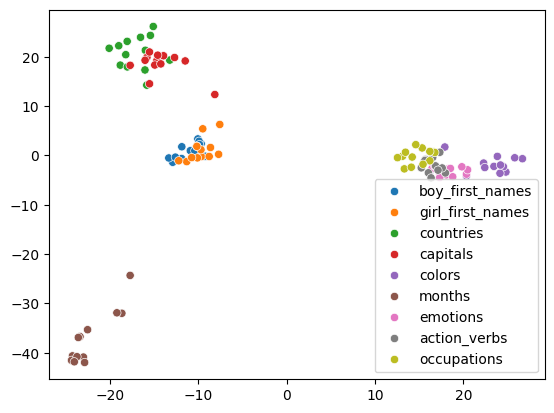

In [83]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
fig = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=embedding_classes)

In [84]:
type(fig)

matplotlib.axes._axes.Axes

In [15]:
fig = fig.get_figure()
fig.savefig("gemma-3-27b-it_emb.png")

In [19]:
import plotly.express as px
import numpy as np

In [20]:
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X)

In [21]:
fig = px.scatter_3d(
    X_pca3, x=0, y=1, z=2, color=embedding_classes, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    width=650, height=500
)

fig.show()

In [22]:
print(f"{pca.explained_variance_ratio_=}")
print(f"{pca3.explained_variance_ratio_=}")

pca.explained_variance_ratio_=array([0.04116973, 0.03895879], dtype=float32)
pca3.explained_variance_ratio_=array([0.04116974, 0.03895883, 0.03175575], dtype=float32)


### With t-SNE

<Axes: >

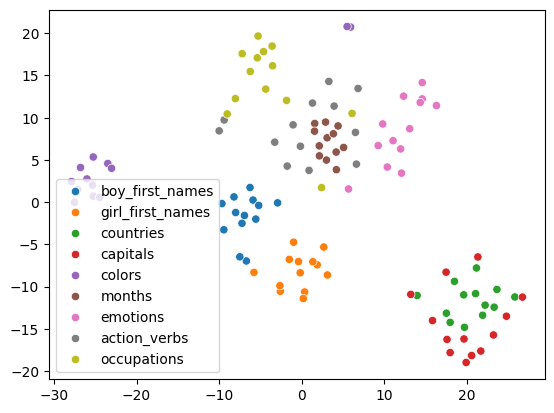

In [68]:
tsne = TSNE(n_components=2, perplexity=10)
X = SS.fit_transform(embedding_np)
X_tsne = tsne.fit_transform(X)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=embedding_classes)

<Axes: >

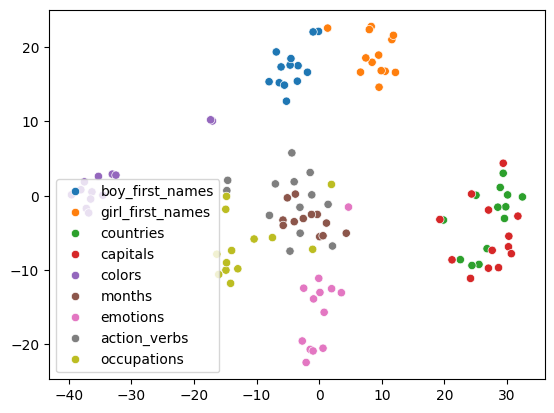

In [69]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate=1)
X = SS.fit_transform(embedding_np)
X_tsne = tsne.fit_transform(X)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=embedding_classes)

In [70]:
tsne = TSNE(n_components=3, perplexity=5, learning_rate=1, early_exaggeration=20)
components_tsne = tsne.fit_transform(X)

fig = px.scatter_3d(
    components_tsne, x=0, y=1, z=2, color=embedding_classes, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    width=650, height=500
)
fig.show()

### With umap

In [71]:
import umap

In [72]:
um = umap.UMAP()
X_fit = um.fit(X)           # we'll use X_fit later
X_umap = um.transform(X)


/Users/john/venv/ctm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/john/venv/ctm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



<Axes: >

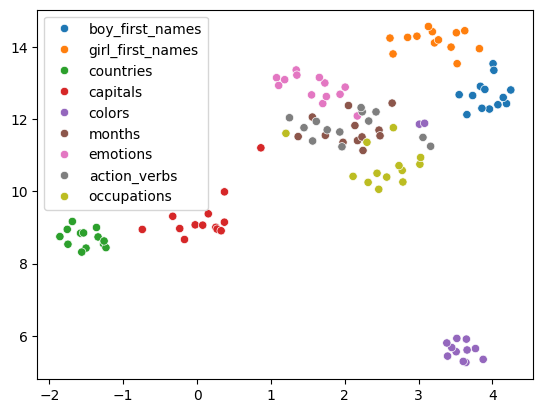

In [73]:
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=embedding_classes)

In [74]:
um = umap.UMAP(n_components=3)
components_umap = um.fit_transform(X)
fig = px.scatter_3d(
    components_umap, x=0, y=1, z=2, color=embedding_classes, size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    width=650, height=500
)
fig.show()

/Users/john/venv/ctm/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [94]:
from umap import plot

/Users/john/venv/ctm/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

/Users/john/venv/ctm/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature

/Users/john/venv/ctm/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning:

Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature



/Users/john/venv/ctm/lib/python3.12/site-packages/datashader/transfer_functions/__init__.py:340: RuntimeWarning:

invalid value encountered in divide



<Axes: >

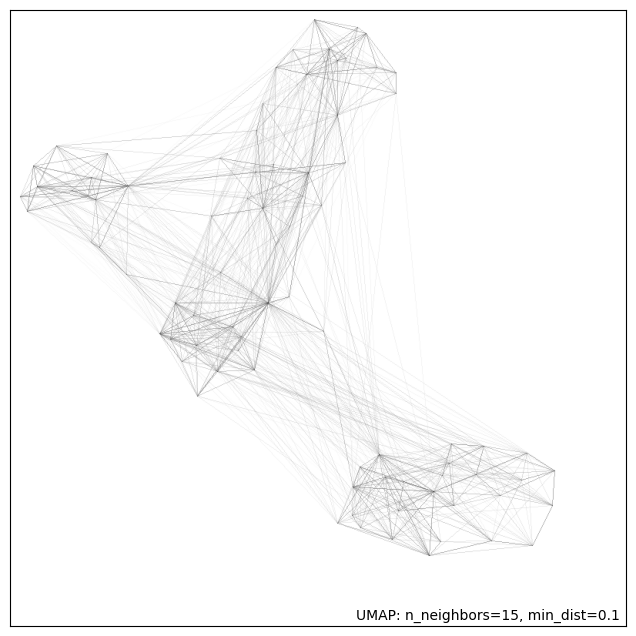

In [96]:
plot.connectivity(X_fit, show_points=True)

## Work on next layers

In [74]:
insp.tokenizer.add_bos_token

True

In [36]:
tokens, classes = [], []
for cat, wl in word_lists.items():
    we = {}
    for w in wl:
        _tok = insp.tokenizer.encode(f' {w}', return_tensors="pt").to(device)[:,-1:]
        if len(_emb.shape) > 1:
            print(w, _emb.shape)
            continue
        tokens.append(_tok)
        classes.append((cat, w))

tokens = torch.concat(tokens)
print(f"{tokens.shape=}")

tokens.shape=torch.Size([116, 1])


In [78]:
import re
names = []
for n, _ in insp.model.named_modules():
    names.append(n)

In [37]:
name_regex = r"model.language_model.layers.\d+$"
name_pattern = r"model.lanuage_model.layers.{layer_idx}"
insp.add(op.GetOutput(), name_regex=name_regex)

Added to layer ['model.language_model.layers.0', 'model.language_model.layers.1', 'model.language_model.layers.2', 'model.language_model.layers.3', 'model.language_model.layers.4', 'model.language_model.layers.5', 'model.language_model.layers.6', 'model.language_model.layers.7', 'model.language_model.layers.8', 'model.language_model.layers.9', 'model.language_model.layers.10', 'model.language_model.layers.11', 'model.language_model.layers.12', 'model.language_model.layers.13', 'model.language_model.layers.14', 'model.language_model.layers.15', 'model.language_model.layers.16', 'model.language_model.layers.17', 'model.language_model.layers.18', 'model.language_model.layers.19', 'model.language_model.layers.20', 'model.language_model.layers.21', 'model.language_model.layers.22', 'model.language_model.layers.23', 'model.language_model.layers.24', 'model.language_model.layers.25', 'model.language_model.layers.26', 'model.language_model.layers.27', 'model.language_model.layers.28', 'model.l

In [47]:
with insp.ctx(detach_state=True) as state:
    out = insp.model(tokens)

In [53]:
state['output']['model.language_model.layers.0'][0].shape

torch.Size([116, 1, 5376])

In [61]:
layer0 = state['output']['model.language_model.layers.61'][0].squeeze().cpu().numpy()

In [62]:
SS = StandardScaler()
wlayer0 = SS.fit_transform(layer0)
wlayer0.shape

(116, 5376)

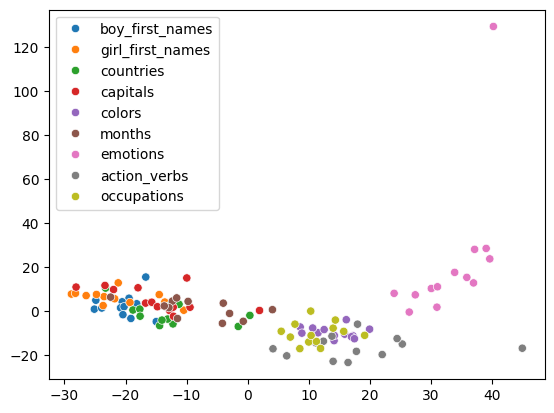

In [63]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(wlayer0)
fig2 = sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=embedding_classes)

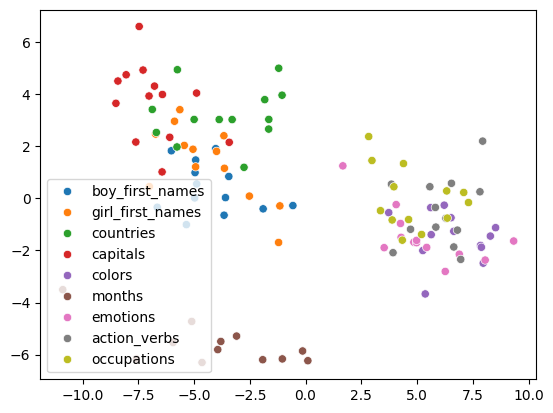

In [64]:
pca2 = PCA(n_components=2)
X_pca2 = pca.transform(wlayer0)
fig2 = sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=embedding_classes)

## When there are context

The extra context can be in the form:

- subjective - noun
- qualifier - adjective: blue, dark blue, light blue
- multi-semantic word in different contexts
- different forms of verb (e.g. did, done, doing, does)
- use of words in different scenarios: code, poem, math, reasoning...
- different by token representation: e.g blue (single token) vs b-l-u-e (4 separate tokens)

In [4]:
from dawnet.diagnose.vis_transformer_manifold import ManifoldExperiment

In [5]:
from dawnet.prompts import get_words
word_lists = get_words()

In [6]:
exp = ManifoldExperiment(insp)
for _c, _w in word_lists.items():
    for _e in _w:
        exp.add_phrase(_e, label=_c, skip_add_bos=False)

exp.collect_activations(embed_name="model.embed_tokens", layers=insp.get_layers(name_regex=r"^model.layers.\d+$"))
exp.build_coordinates()

# exp.add_phrase("she is feeling blue", label="feeling blue", style="x", size=2, skip_add_bos=False)
# exp.add_phrase("royal blue", label="light blue", size=2, skip_add_bos=False)
# exp.add_phrase("dark red", label="light red", size=2, skip_add_bos=False)
# exp.add_phrase("phone", label="the phone", size=2, skip_add_bos=False)

Added to layer ['model.embed_tokens', 'model.layers.0', 'model.layers.1', 'model.layers.2', 'model.layers.3', 'model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15', 'model.layers.16', 'model.layers.17', 'model.layers.18', 'model.layers.19', 'model.layers.20', 'model.layers.21', 'model.layers.22', 'model.layers.23', 'model.layers.24', 'model.layers.25', 'model.layers.26', 'model.layers.27', 'model.layers.28', 'model.layers.29', 'model.layers.30', 'model.layers.31']


In [26]:
print(exp.search_phrase("blue"))
exp.wlabels[53] = 'color blue'
exp.wsizes[53] = 2

[(53, (53,)), (116, (116,)), (117, (117,))]


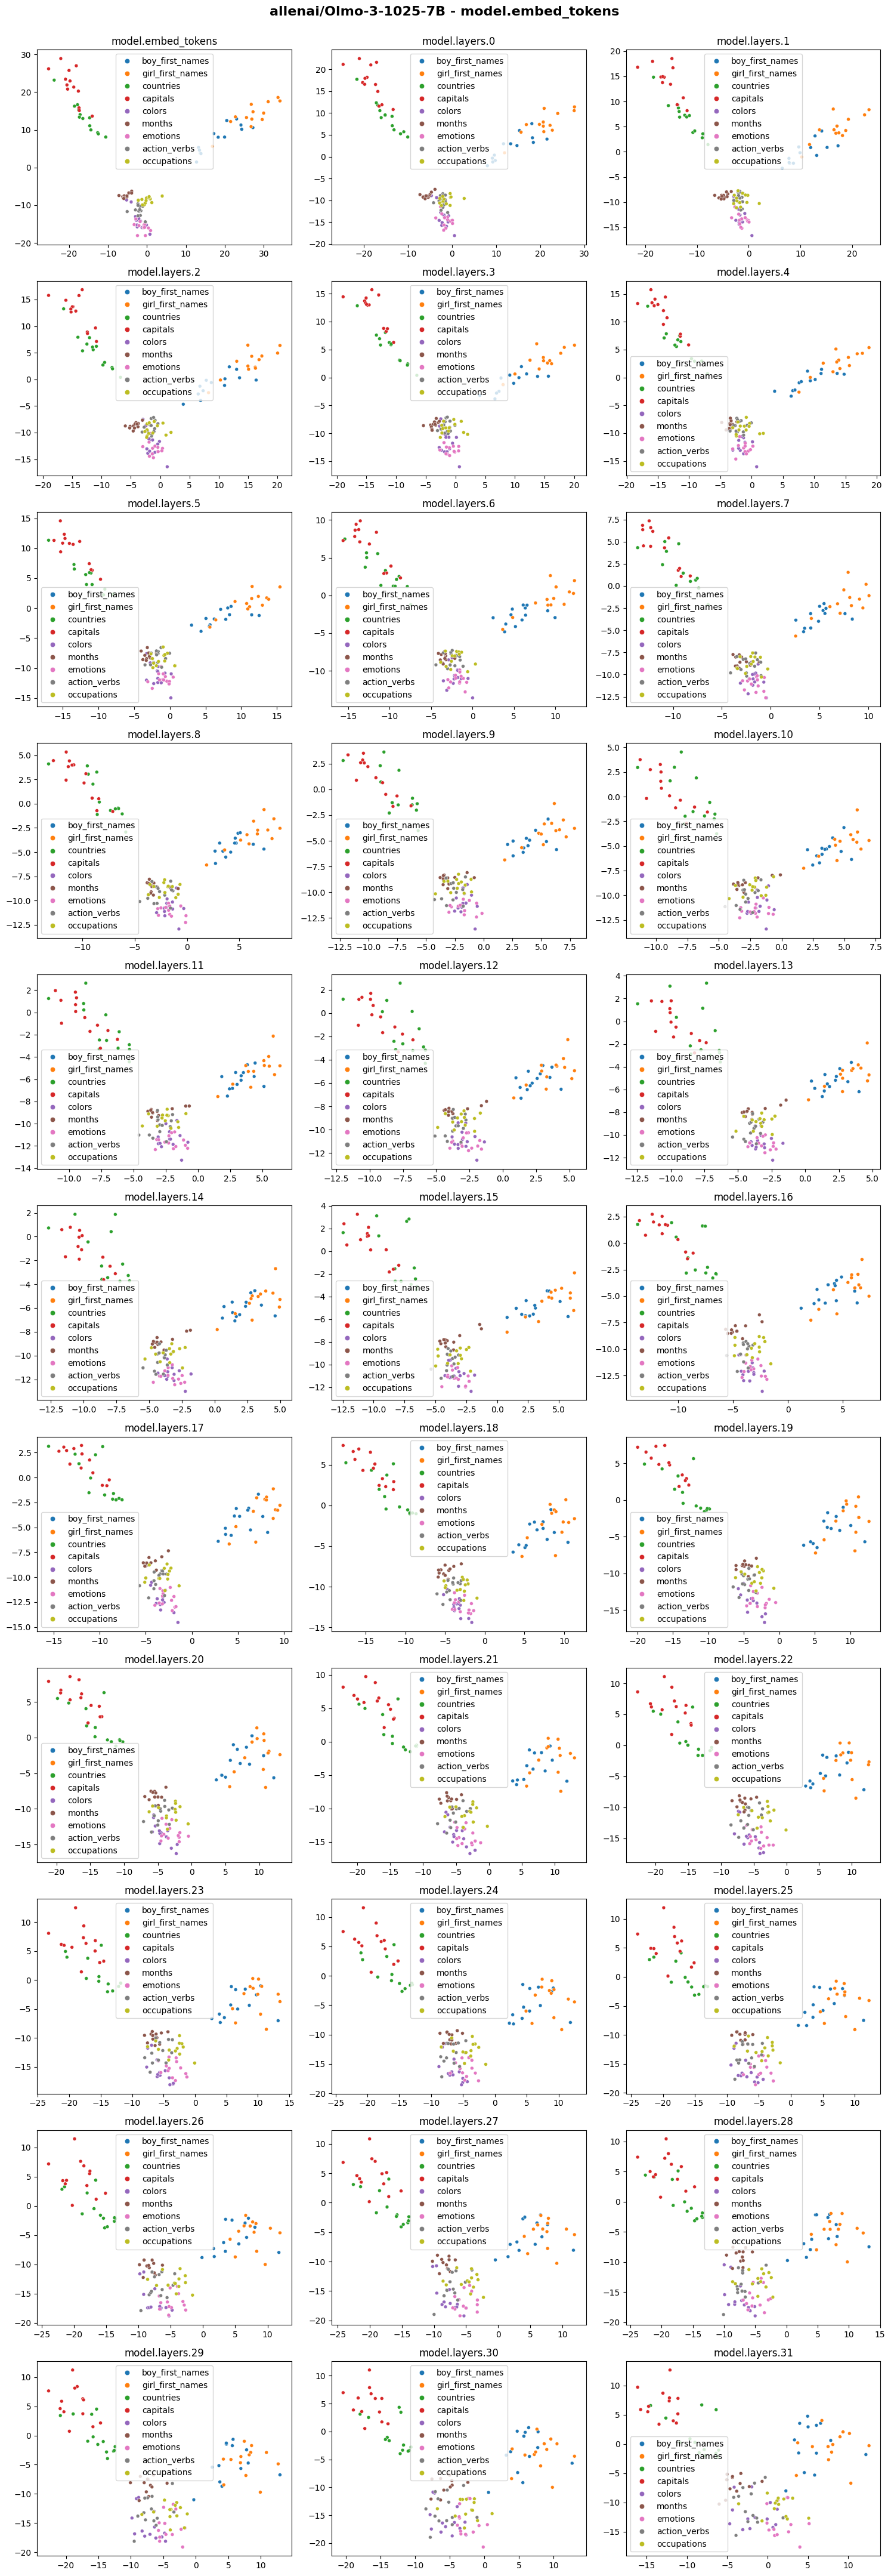

In [8]:
# fig = exp.show_notebook(active_labels={"color blue", "feeling blue", "dark blue", "light blue", "the phone", "light red", "emotions", "colors"})
# fig = exp.show_notebook(coord_system="model.embed_tokens", layers=[
#   "model.embed_tokens", "model.layers.0", "model.layers.1", "model.layers.2", "model.layers.3", "model.layers.4", "model.layers.5", "model.layers.6",
#   "model.layers.33", "model.layers.34", "model.layers.35"
# ], max_cols=2)

fig = exp.show_notebook(coord_system="model.embed_tokens")
# for l in ["model.embed_tokens", "model.layers.0", "model.layers.1", "model.layers.2", "model.layers.3", "model.layers.4", "model.layers.5", "model.layers.6", "model.layers.33", "model.layers.34", "model.layers.35"]:
#   fig = exp.show_notebook(coord_system="model.embed_tokens", layers=[
#     l,
#   ])
#   fig.savefig(f"/Users/john/trducng.github.io/assets/imgs/ttcm/qwen3-4b-instruct-2507_m.et__{l}.webp")

fig

In [160]:
fig.savefig("/Users/john/trducng.github.io/assets/imgs/ttcm/qwen3-4b-instruct-2507_m.et.webp")

In [76]:
(pca3.components_ > 0).astype(int)

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 1, 0]])

In [55]:
pca3 = exp.pcas['model.layers.3'][1]
pca5 = exp.pcas['model.layers.5'][1]

In [57]:
print(pca3.components_)
pca5.components_[1] = pca5.components_[1] * -1

[[ 0.01536824  0.005176   -0.01624817 ...  0.02336063 -0.03098983
   0.00347135]
 [ 0.02899667 -0.02999878 -0.01327507 ...  0.00549573  0.00538837
  -0.00197586]]


In [ ]:
exp.show_notebook(coord_system="transformer.wte")

In [18]:
result = exp.collect(embed_name="transformer.wte", layers=insp.get_layers(name_regex=r"^transformer.h.\d+$"))

Added to layer ['transformer.wte', 'transformer.h.0', 'transformer.h.1', 'transformer.h.2', 'transformer.h.3', 'transformer.h.4', 'transformer.h.5', 'transformer.h.6', 'transformer.h.7', 'transformer.h.8', 'transformer.h.9', 'transformer.h.10', 'transformer.h.11']


In [ ]:
# gemma3-27b
fig = exp.show_notebook()

In [26]:
fig.savefig("gemma3-27b-embeddings.png")

<Axes: >

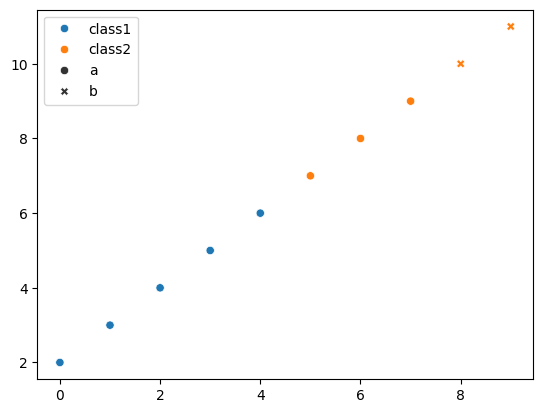

In [117]:
sns.scatterplot(
  x=list(range(10)),
  y=[_+2 for _ in range(10)],
  hue=["class1" for _ in range(5)]+["class2" for _ in range(5)],
  style=["a" for _ in range(8)]+["b" for _ in range(2)],
  legend="full",
)